In [ ]:
!pip install pyspark scikit-learn pandas

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor , plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b517ba390b4583323e6e20522b47a1d1dd38450141058b640b318fb9d6e9aaf4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *

# Initialize the Spark session
spark = SparkSession.builder.appName("msds697").getOrCreate()

# Function to load CSV dataset
def load_dataset(file_path):
    # Read the CSV file into a Spark DataFrame
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    return df

# Provide the path to the uploaded file
file_path = '/content/owid-covid-data_india.csv'

# Load the dataset
df_read = load_dataset(file_path)
covid_data = df_read.toPandas()
# Show the first 10 rows of the DataFrame
df_read.show(10)


+--------+---------+--------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+----------------------------------

In [ ]:
covid_data.fillna(covid_data.median(numeric_only=True), inplace=True)
covid_data.fillna(covid_data.mode().iloc[0], inplace=True)

In [ ]:
df_read.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: string (nullable = true)
 |-- icu_patients_per_million: string (nullable = true)
 |-- hosp_patients: string (nullable = true)
 |-- hosp_patients_per_mil

In [ ]:
df_read.groupBy('diabetes_prevalence').count().show()

+-------------------+-----+
|diabetes_prevalence|count|
+-------------------+-----+
|              10.39| 1390|
+-------------------+-----+



In [ ]:
df_read.groupBy('new_cases').count().show()

+---------+-----+
|new_cases|count|
+---------+-----+
|     6654|    1|
|    11458|    1|
|    19079|    1|
|    24354|    1|
|     7554|    1|
|     1088|    1|
|     1829|    1|
|     7240|    1|
|      833|    1|
|     1580|    1|
|     1990|    1|
|    31118|    1|
|    14148|    1|
|      243|    1|
|    39742|    1|
|    37593|    1|
|     1270|    1|
|       85|    1|
|    11713|    1|
|   295041|    1|
+---------+-----+
only showing top 20 rows



In [ ]:
df_read.groupBy('total_cases').count().show()

+-----------+-----+
|total_cases|count|
+-----------+-----+
|      19984|    1|
|      74281|    1|
|    9351109|    1|
|   44674649|    1|
|   44994543|    1|
|     145380|    1|
|    4930236|    1|
|   33316755|    1|
|   44680094|    1|
|   44994819|    1|
|         31|    1|
|    9932547|    1|
|   31856757|    1|
|   43009390|    1|
|        137|    1|
|    1003832|    1|
|    4280422|    1|
|    7175880|    1|
|   10557985|    1|
|   23703665|    1|
+-----------+-----+
only showing top 20 rows



In [ ]:
cat_col = ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
    'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
    'new_cases_per_million', 'new_cases_smoothed_per_million',
    'total_deaths_per_million', 'new_deaths_per_million',
    'new_deaths_smoothed_per_million', 'reproduction_rate',
    'icu_patients', 'icu_patients_per_million', 'hosp_patients',
    'hosp_patients_per_million', 'total_tests', 'new_tests',
    'total_tests_per_thousand', 'new_tests_per_thousand',
    'new_tests_smoothed', 'positive_rate', 'tests_per_case',
    'stringency_index', 'population_density', 'median_age',
    'aged_65_older', 'aged_70_older', 'gdp_per_capita',
    'diabetes_prevalence', 'handwashing_facilities',
    'hospital_beds_per_thousand', 'life_expectancy',
    'human_development_index']

In [ ]:
from pyspark.ml.feature import StringIndexer

def indexStringColumns(df, cols):
    newdf = df

    for c in cols:
        si = StringIndexer(inputCol=c, outputCol=c+"-num")
        sm = si.fit(newdf)

        newdf = sm.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-num", c)
    return newdf


In [ ]:
df_read.show(4)

+--------+---------+--------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+----------------------------------

In [ ]:
sidf = indexStringColumns(df_read,cat_col)

In [ ]:
from pyspark.ml.feature import OneHotEncoder

def oneHotEncodeColumns(df, cols):
    newdf = df
    for c in cols:
        ohe = OneHotEncoder(inputCol=c, outputCol=c+"-onehot", dropLast=False, handleInvalid='keep')
        ohe_model = ohe.fit(newdf)

        newdf = ohe_model.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-onehot", c)
    return newdf


In [ ]:
oh_col = ['total_cases', 'new_cases', 'new_cases_smoothed',
    'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
    'new_cases_per_million', 'new_cases_smoothed_per_million',
    'total_deaths_per_million', 'new_deaths_per_million',
    'new_deaths_smoothed_per_million', 'reproduction_rate',
    'icu_patients', 'icu_patients_per_million', 'hosp_patients',
    'hosp_patients_per_million', 'total_tests', 'new_tests',
    'total_tests_per_thousand', 'new_tests_per_thousand',
    'new_tests_smoothed', 'positive_rate', 'tests_per_case',
    'stringency_index', 'population_density', 'median_age',
    'aged_65_older', 'aged_70_older', 'gdp_per_capita',
    'diabetes_prevalence', 'handwashing_facilities',
    'hospital_beds_per_thousand', 'life_expectancy',
    'human_development_index']
ohdf = oneHotEncodeColumns(sidf,oh_col)

In [ ]:
va_col = ['total_cases', 'new_cases', 'new_cases_smoothed',
    'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
    'new_cases_per_million', 'new_cases_smoothed_per_million',
    'total_deaths_per_million', 'new_deaths_per_million',
    'new_deaths_smoothed_per_million', 'reproduction_rate',
    'icu_patients', 'icu_patients_per_million', 'hosp_patients',
    'hosp_patients_per_million', 'total_tests', 'new_tests',
    'total_tests_per_thousand', 'new_tests_per_thousand',
    'new_tests_smoothed', 'positive_rate', 'tests_per_case',
    'stringency_index', 'population_density', 'median_age',
    'aged_65_older', 'aged_70_older', 'gdp_per_capita',
    'diabetes_prevalence', 'handwashing_facilities',
    'hospital_beds_per_thousand', 'life_expectancy',
    'human_development_index']

In [ ]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(outputCol="features", inputCols=va_col,handleInvalid='skip')
vadf = va.transform(ohdf)

from pyspark.ml.feature import Imputer
imputer = Imputer(
    inputCols=['total_deaths'],
    outputCols=["{}_imputed".format(c) for c in ['total_deaths']]
).setStrategy("mean") # or other strategy



In [ ]:
cleandf = vadf.select('features','total_deaths').withColumnRenamed('total_deaths','label')


**K MEANS CLUSTERING**

In [ ]:

# Check for missing values before dropping
print("Missing values in X_train before dropping:", X_train.isnull().sum().sum())

X_train_dropna = X_train.dropna()
y_train_dropna = y_train.loc[X_train_dropna.index]

print("Missing values in X_train after dropping:", X_train_dropna.isnull().sum().sum())
print("Number of samples in X_train after dropping:", X_train_dropna.shape[0])

# Now use the data without missing values for KMeans if there are samples left
if X_train_dropna.shape[0] > 0:
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(X_train_dropna)
    # ... (rest of the code)
else:
    print("Cannot perform KMeans clustering: No samples remaining after dropping missing values.")

Missing values in X_train before dropping: 0
Missing values in X_train after dropping: 0
Number of samples in X_train after dropping: 1112


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Calculate the number of missing values in each column
missing_values = X_train.isnull().sum()

# Get the names of columns with missing values
columns_with_missing = missing_values[missing_values > 0].index

# Drop the columns with missing values
X_train_no_missing = X_train.drop(columns_with_missing, axis=1)

# Print the remaining columns
print(X_train_no_missing.columns)

Index(['diabetes_prevalence', 'male_smokers', 'female_smokers', 'date'], dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


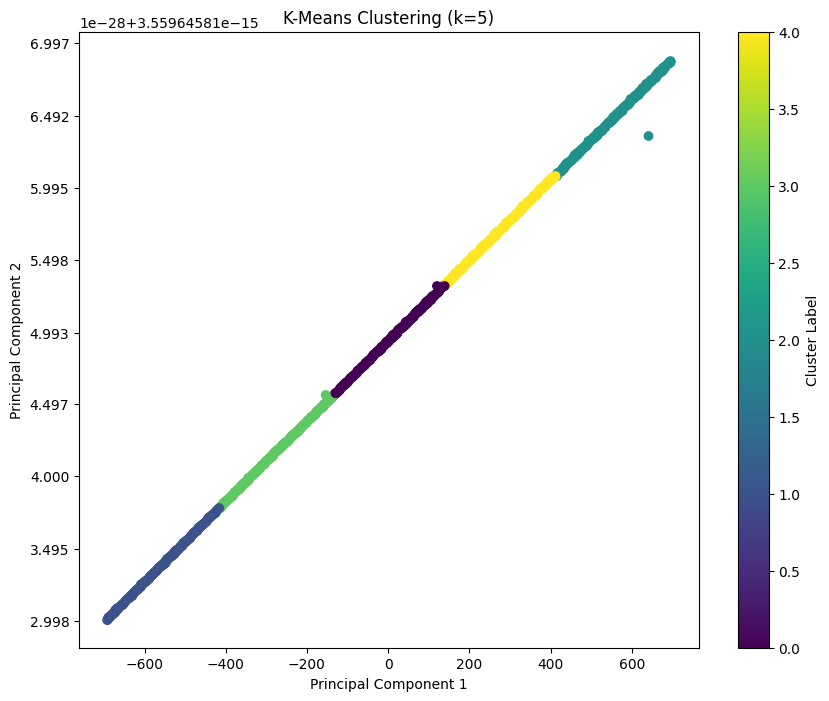

In [ ]:
selected_features = [
    'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'total_deaths', 'new_deaths', 'new_deaths_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'positive_rate', 'tests_per_case',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'diabetes_prevalence',
       'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index']


# Define the target variable
target_variable = 'total_deaths'

# Create a new DataFrame with selected features and the target variable
df_selected = covid_data[selected_features + [target_variable]]

# Split the data into training and testing sets
X = df_selected[selected_features]
y = df_selected[target_variable]

# Calculate the number of missing values in each column
missing_values = X_train.isnull().sum()

# Get the names of columns with missing values
columns_with_missing = missing_values[missing_values > 0].index

# Drop the columns with missing values
X_train_no_missing = X_train.drop(columns_with_missing, axis=1)

# Now use the data without missing values for KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_no_missing)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_no_missing)

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('K-Means Clustering (k=5)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()





**LINEAR** **REGRESSION**

Linear Regression Performance
MAE: 0.1177733950307078
MSE: 0.051765461482575735
RMSE: 0.22752024411593738
R2 Score: 0.09834529519509061


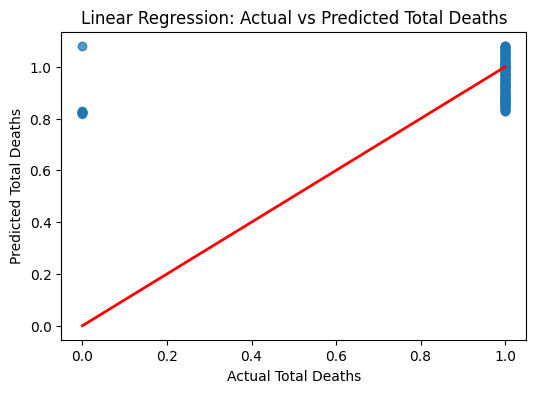

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Calculate the number of missing values in each column
missing_values = X_train.isnull().sum()

# Get the names of columns with missing values
columns_with_missing = missing_values[missing_values > 0].index

# Drop the columns with missing values
X_train_no_missing = X_train.drop(columns_with_missing, axis=1)

# Also, drop the corresponding columns in X_test for consistency
X_test_no_missing = X_test.drop(columns_with_missing, axis=1)

# Now use the data without missing values for Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_no_missing, y_train) # Use X_train_no_missing here
y_pred_lr = lin_reg.predict(X_test_no_missing) # And X_test_no_missing here

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance")
print(f'MAE: {mae_lr}')
print(f'MSE: {mse_lr}')
print(f'RMSE: {rmse_lr}')
print(f'R2 Score: {r2_lr}')

# Plotting
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Total Deaths')
plt.ylabel('Predicted Total Deaths')
plt.title('Linear Regression: Actual vs Predicted Total Deaths')
plt.show()


  **RANDOM FOREST ALGORITHM**


Random Forest Performance
MAE: 0.005827338129496404
MSE: 0.004176978417266187
RMSE: 0.0646295475557905
R2 Score: 0.927245075501465


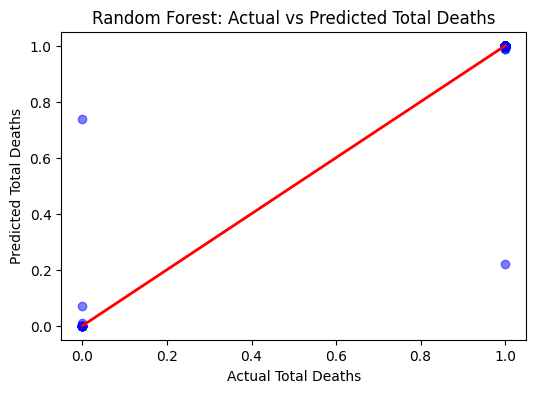

In [ ]:
rf_reg = RandomForestRegressor(random_state=42)

# Handle missing values in X_train using imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Choose an appropriate strategy
X_train_imputed = imputer.fit_transform(X_train)

# Fit the model using the imputed data
rf_reg.fit(X_train_imputed, y_train)

# Impute missing values in X_test using the same imputer
X_test_imputed = imputer.transform(X_test)

y_pred_rf = rf_reg.predict(X_test_imputed)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance")
print(f'MAE: {mae_rf}')
print(f'MSE: {mse_rf}')
print(f'RMSE: {rmse_rf}')
print(f'R2 Score: {r2_rf}')


# Plotting the actual vs predicted values
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Total Deaths')
plt.ylabel('Predicted Total Deaths')
plt.title('Random Forest: Actual vs Predicted Total Deaths')
plt.show()

**DECISION TREE**


Decision Tree Performance
MAE: 0.007194244604316547
MSE: 0.007194244604316547
RMSE: 0.08481889296799709
R2 Score: 0.8746901059274285


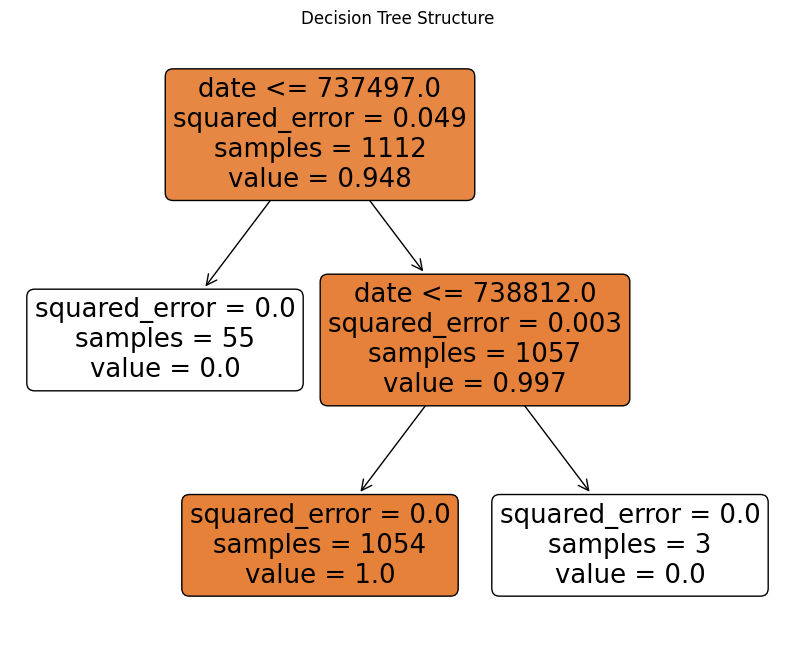

In [ ]:
# Train and evaluate Decision Tree model
dt_reg = DecisionTreeRegressor(random_state=42)

# Handle missing values (e.g., using imputation)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Impute missing values in both training and testing sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) # Apply the same imputation to X_test

dt_reg.fit(X_train_imputed, y_train)  # Use imputed data for training
y_pred_dt = dt_reg.predict(X_test_imputed)  # Use imputed data for prediction

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
r2_dt = r2_score(y_test, y_pred_dt)

print("\nDecision Tree Performance")
print(f'MAE: {mae_dt}')
print(f'MSE: {mse_dt}')
print(f'RMSE: {rmse_dt}')
print(f'R2 Score: {r2_dt}')

# Plotting the Decision Tree
plt.figure(figsize=(10, 8))
plot_tree(dt_reg, filled=True, feature_names=X_train.columns, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

In [ ]:
#Divide the dataset into training and vaildation sets.
splits = cleandf.randomSplit([0.7, 0.3])

#cache() : the algorithm is interative and training and data sets are going to be reused many times.
train = splits[0].cache()
valid = splits[1].cache()

In [ ]:
splits[0].printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



# PREDICTING THE DEATH USING RANDOM FOREST

Random Forest Classification Performance
Accuracy: 0.8525179856115108
Precision: 0.8525179856115108
Recall: 1.0
Confusion Matrix:
[[  0  41]
 [  0 237]]


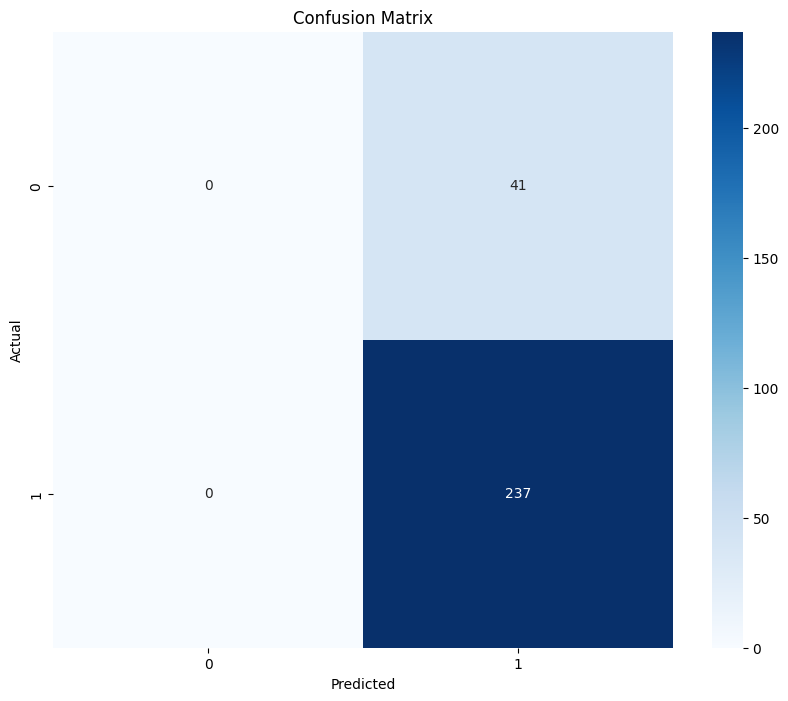

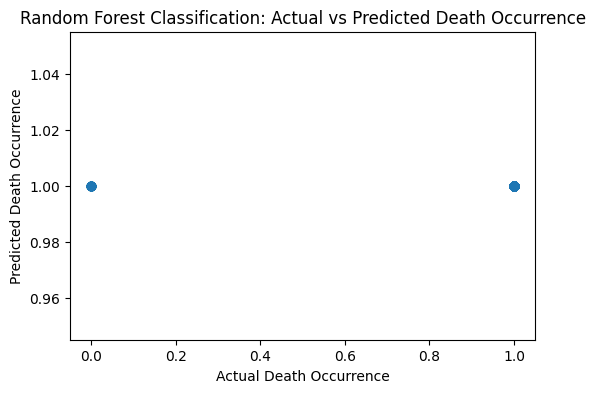

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Load the data
file_path = '/content/owid-covid-data_india.csv'
data = pd.read_csv(file_path)



# Extract relevant columns: Assuming they are named 'diabetes_prevalance', 'male_smokers', 'female_smokers', and 'death_rate'
# Generate a binary target variable 'death_occurrence': 1 if death_rate > threshold, else 0
threshold = 0.01  # Adjust the threshold as needed
data['death_occurrence'] = (data['new_deaths'] > threshold).astype(int)



X = data[['diabetes_prevalence', 'male_smokers', 'female_smokers']]  # Fix the typo
y = data['death_occurrence']

# Check for missing values and handle them
X = X.dropna()
y = y[X.index]  # Ensure y is aligned with X after dropping missing values in X

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Calculate performance metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Classification Performance")
print(f'Accuracy: {accuracy_rf}')
print(f'Precision: {precision_rf}')
print(f'Recall: {recall_rf}')
print("Confusion Matrix:")
print(cm_rf)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plotting Actual vs Predicted Death Occurrence
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Actual Death Occurrence')
plt.ylabel('Predicted Death Occurrence')
plt.title('Random Forest Classification: Actual vs Predicted Death Occurrence')
plt.show()


**PREDICTING THE DEATH USING THE SAMPLE INPUT**

<ipython-input-58-e9bf155e5a33>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['date'] = pd.to_datetime(X['date'], format='%d-%m-%Y').map(pd.Timestamp.toordinal)  # Specify the correct format


Random Forest Classification Performance
Accuracy: 0.9928057553956835
Precision: 0.9961685823754789
Recall: 0.9961685823754789
Confusion Matrix:
[[ 16   1]
 [  1 260]]


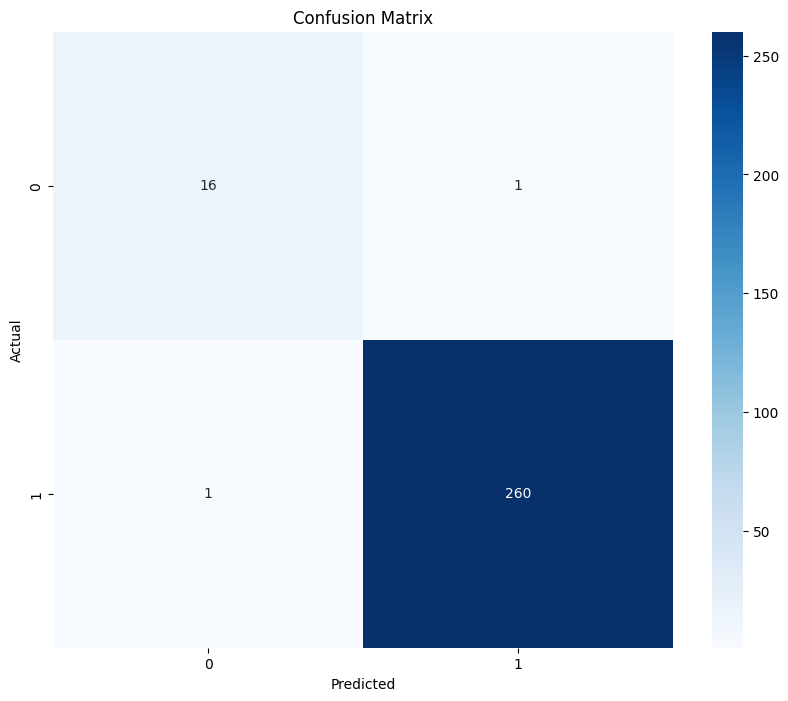

Prediction for new data: Will there be deaths? No


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the data
file_path = '/content/owid-covid-data_india.csv'
data = pd.read_csv(file_path)



# Extract relevant columns: Correct the typo in 'diabetes_prevalence'
features = ['diabetes_prevalence', 'male_smokers', 'female_smokers', 'date']  # Corrected column name
target = 'total_deaths'

# Create a binary target variable: 1 if there are any deaths, 0 otherwise
data['death_occurrence'] = (data[target] > 0).astype(int)

# Extract the features and target
X = data[features]
y = data['death_occurrence']

# Convert 'date' to numerical format (e.g., ordinal date)
# Convert 'date' to numerical format (e.g., ordinal date)
X['date'] = pd.to_datetime(X['date'], format='%d-%m-%Y').map(pd.Timestamp.toordinal)  # Specify the correct format
# Check for missing values and handle them
X = X.dropna()
y = y[X.index]  # Ensure y is aligned with X after dropping missing values in X

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
cm = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Classification Performance")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Example of how to use the model to predict new data
new_data = pd.DataFrame({
    'diabetes_prevalence': [5.5],
    'male_smokers': [20.0],
    'female_smokers': [15.0],
    'date': [pd.Timestamp('2024-06-24').toordinal()]
})

prediction = rf_clf.predict(new_data)
result = 'Yes' if prediction[0] == 1 else 'No'
print(f"Prediction for new data: Will there be deaths? {result}")
